In [ ]:
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from prefixspan import PrefixSpan
import re
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
# Visualization
plt.style.use('default')
sns.set_palette("husl")

df = pd.read_csv('../datasets/udemy_data_final_fix.csv')
print(f"📊 Loaded {len(df)} courses")
df.head()

📊 Loaded 10181 courses


,timestamp,course_url,title,headline,is_bestseller,rating,num_reviews,num_students,instructor,language,price,discount,related_topics,sections,lectures,total_length
0,2025-10-06 19:36:49,https://www.udemy.com/course/machinelearning/,"Machine Learning A-Z: AI, Python & R + ChatGPT...",Learn to create Machine Learning Algorithms in...,Yes,4.5,"200,080","1,159,767",Kirill,English,369000.0,81%,"Machine Learning, Data Science, Development",46.0,386.0,42h 44m
1,2025-10-06 19:37:05,https://www.udemy.com/course/complete-machine-...,"Complete Data Science,Machine Learning,DL,NLP ...","Master the theory, practice,and math behind Da...",Yes,4.5,"2,700","107,821",Krish,English,349000.0,78%,"Data Science, Other IT & Software, IT & Software",63.0,429.0,99h 10m
2,2025-10-06 19:37:19,https://www.udemy.com/course/complete-machine-...,"Complete A.I. & Machine Learning, Data Science...","Learn Data Science, Data Analysis, Machine Lea...",No,4.6,"28,660","153,392",Andrei,English,339000.0,82%,"Data Science, Development",21.0,384.0,44h 0m
3,2025-10-06 19:38:12,https://www.udemy.com/course/machine-learning-...,Mathematical Foundations of Machine Learning,Essential Linear Algebra and Calculus Hands-On...,Yes,4.6,"7,816","137,461",Dr,English,389000.0,82%,"Math, Data Science, Development",11.0,114.0,16h 25m
4,2025-10-06 19:38:54,https://www.udemy.com/course/machine-learning-...,Machine Learning for Absolute Beginners - Level 1,Learn the Fundamental Concepts of Artificial I...,No,4.5,"29,071","115,825",Idan,English,339000.0,24%,"Machine Learning, Data Science, Development",8.0,59.0,4h 27m


In [59]:
"""
🎯 Mục tiêu: Chuẩn hóa dữ liệu để phù hợp với PrefixSpan
"""

# 2.1: Clean numeric columns
df['num_students'] = df['num_students'].str.replace(',', '').astype(float)
df['num_reviews'] = df['num_reviews'].str.replace(',', '').astype(float)
df['discount'] = df['discount'].str.replace('%', '').astype(float) / 100

# 2.2: Convert duration
def parse_duration(duration_str):
    """Convert '10h30m' → 630 minutes"""
    if pd.isna(duration_str):
        return None
    hours = re.search(r'(\d+)h', str(duration_str))
    minutes = re.search(r'(\d+)m', str(duration_str))
    total = (int(hours.group(1)) if hours else 0) * 60
    total += (int(minutes.group(1)) if minutes else 0)
    return total

df['duration_minutes'] = df['total_length'].apply(parse_duration)

print("✅ Preprocessing done")
df[['title', 'num_students', 'duration_minutes']].head()

✅ Preprocessing done


,title,num_students,duration_minutes
0,"Machine Learning A-Z: AI, Python & R + ChatGPT...",1159767.0,2564
1,"Complete Data Science,Machine Learning,DL,NLP ...",107821.0,5950
2,"Complete A.I. & Machine Learning, Data Science...",153392.0,2640
3,Mathematical Foundations of Machine Learning,137461.0,985
4,Machine Learning for Absolute Beginners - Level 1,115825.0,267


In [60]:
duplicates = df.duplicated(subset=['title'])
dup_count=duplicates.sum()

if dup_count>0:
    print(f"⚠️  Found {dup_count} duplicate rows ({(dup_count/len(df)*100):.2f}%)")
    print(f"Sample duplicate rows:")
    print(df[duplicates].head().to_string(index=False))
    # Xóa các bản sao dựa trên tiêu đề, giữ lại bản sao đầu tiên
    df.drop_duplicates(subset=['title'], keep='first', inplace=True)
    print(f"✅ Removed {dup_count} duplicate rows")
else:
    print("✅ No duplicate rows found")


⚠️  Found 2934 duplicate rows (28.82%)
Sample duplicate rows:
          timestamp                                                                               course_url                                                       title                                                                                                                 headline is_bestseller  rating  num_reviews  num_students instructor language    price  discount                                   related_topics  sections  lectures total_length  duration_minutes
2025-10-06 19:52:15                                            https://www.udemy.com/course/machinelearning/ Machine Learning A-Z: AI, Python & R + ChatGPT Prize [2025]      Learn to create Machine Learning Algorithms in Python and R from two Data Science experts. Code templates included.           Yes     4.5     200080.0     1159767.0     Kirill  English 399000.0      0.81      Machine Learning, Data Science, Development      46.0     386.0      42h 44m 

In [ ]:
"""
🎯 Thay vì hard-code skills, ta sẽ:
1. Trích xuất từ khóa quan trọng bằng TF-IDF
2. Lọc bằng domain-specific keywords
3. Cho phép mở rộng tự động
"""

from sklearn.feature_extraction.text import TfidfVectorizer

# 3.1: Combine text fields
df['full_content'] = (
    df['title'].fillna('') + ' ' + 
    df['headline'].fillna('') + ' ' + 
    df['related_topics'].fillna('')
)

# 3.2: Extract top keywords using TF-IDF
vectorizer = TfidfVectorizer(
    max_features=100,      # Top 100 important terms
    ngram_range=(1, 2),    # Unigram + Bigram (e.g., "machine learning")
    stop_words='english',  # Remove common words
    min_df=5,              # At least 5 courses must have this term
    lowercase=True
)

tfidf_matrix = vectorizer.fit_transform(df['full_content'])
feature_names = vectorizer.get_feature_names_out()

print(f"🔍 Extracted {len(feature_names)} key terms from courses")
print("\n📋 Top 30 Terms by TF-IDF:")
print(feature_names[:30])

# 3.3: Define skill categories (flexible, not hard-coded skills)
SKILL_CATEGORIES = {
    'programming_languages': ['python', 'java', 'javascript', 'r programming', 'sql'],
    'ml_frameworks': ['tensorflow', 'pytorch', 'keras', 'scikit', 'scikit learn'],
    'ml_concepts': ['machine learning', 'deep learning', 'neural network', 'ai'],
    'data_tools': ['pandas', 'numpy', 'matplotlib', 'tableau', 'excel'],
    'specialized': ['nlp', 'computer vision', 'reinforcement learning', 'time series'],
    'cloud_devops': ['aws', 'azure', 'docker', 'kubernetes', 'mlops']
}

# Flatten all skills
ALL_SKILLS = [skill for category in SKILL_CATEGORIES.values() for skill in category]

def extract_skills_from_text(text):
    """Extract skills present in text"""
    text_lower = str(text).lower()
    found_skills = []
    for skill in ALL_SKILLS:
        if skill in text_lower:
            found_skills.append(skill)
    return found_skills

df['extracted_skills'] = df['full_content'].apply(extract_skills_from_text)

# Statistics
skill_counts = Counter([skill for skills in df['extracted_skills'] for skill in skills])
print(f"\n📊 Skill Distribution:")
for skill, count in skill_counts.most_common(15):
    print(f"   {skill:30s}: {count:4d} courses ({count/len(df)*100:.1f}%)")

🔍 Extracted 100 key terms from courses

📋 Top 30 Terms by TF-IDF:
['2025' 'academics' 'advanced' 'ai' 'algebra' 'analysis' 'analytics' 'api'
 'app' 'applications' 'apps' 'artificial' 'artificial intelligence' 'aws'
 'basics' 'beginner' 'beginners' 'bootcamp' 'build' 'building' 'business'
 'certifications' 'certifications software' 'chatgpt' 'code' 'coding'
 'complete' 'computer' 'course' 'create']

📊 Skill Distribution:
   ai                            : 1595 courses (22.0%)
   python                        : 1405 courses (19.4%)
   java                          : 1374 courses (19.0%)
   machine learning              :  984 courses (13.6%)
   javascript                    :  532 courses (7.3%)
   sql                           :  322 courses (4.4%)
   deep learning                 :  319 courses (4.4%)
   nlp                           :  280 courses (3.9%)
   aws                           :  174 courses (2.4%)
   pandas                        :  165 courses (2.3%)
   tensorflow         

📊 Difficulty Distribution:
difficulty
Intermediate    4902
Beginner        2141
Advanced         204
Name: count, dtype: int64


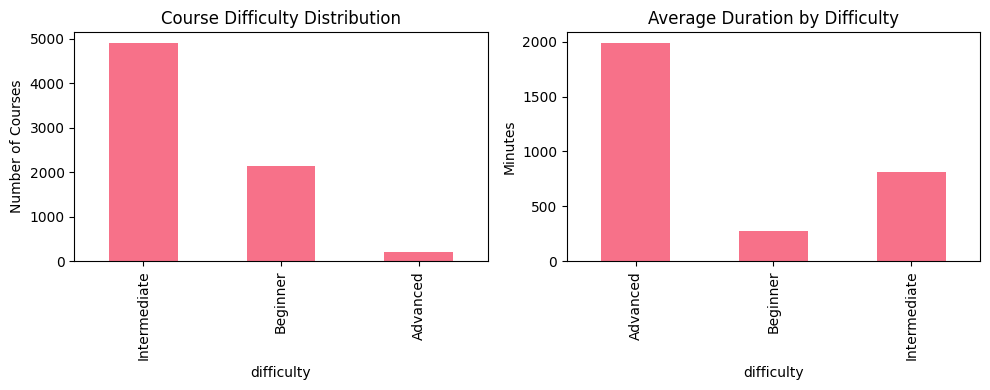

In [ ]:
"""
🎯 Estimate difficulty based on multiple signals:
1. Title keywords
2. Course metadata (duration, prerequisites)
3. Content complexity

Title keywords: "beginner", "advanced", "ultimate"...
Duration: Khóa ngắn (<3h) → Beginner, dài (>20h) → Advanced
Number of skills: Ít kỹ năng → Beginner, nhiều → Advanced
"""

def estimate_difficulty_enhanced(row):
    """Multi-signal difficulty estimation"""
    title = str(row['title']).lower()
    headline = str(row['headline']).lower()
    
    # Signal 1: Title keywords
    beginner_keywords = ['beginner', 'basic', 'fundamental', 'introduction', 
                         'getting started', 'zero to', 'crash course', 'for beginners']
    advanced_keywords = ['advanced', 'expert', 'master', 'professional', 
                        'complete guide', 'ultimate', 'in-depth']
    
    beginner_score = sum(1 for kw in beginner_keywords if kw in title or kw in headline)
    advanced_score = sum(1 for kw in advanced_keywords if kw in title or kw in headline)
    
    # Signal 2: Duration (longer usually more advanced)
    duration = row['duration_minutes']
    duration_score = 0
    if pd.notna(duration):
        if duration < 180:      # < 3 hours
            duration_score = -1  # Likely beginner
        elif duration > 1200:   # > 20 hours
            duration_score = 1   # Likely advanced
    
    # Signal 3: Number of skills (more skills = more advanced)
    num_skills = len(row['extracted_skills'])
    skill_score = 0
    if num_skills <= 2:
        skill_score = -1
    elif num_skills >= 5:
        skill_score = 1
    
    # Combine signals
    total_score = beginner_score * (-1) + advanced_score + duration_score + skill_score
    
    if total_score < -1:
        return 'Beginner'
    elif total_score > 1:
        return 'Advanced'
    else:
        return 'Intermediate'

df['difficulty'] = df.apply(estimate_difficulty_enhanced, axis=1)

print("📊 Difficulty Distribution:")
print(df['difficulty'].value_counts())

# Visualize
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
df['difficulty'].value_counts().plot(kind='bar')
plt.title('Course Difficulty Distribution')
plt.ylabel('Number of Courses')

plt.subplot(1, 2, 2)
df.groupby('difficulty')['duration_minutes'].mean().plot(kind='bar')
plt.title('Average Duration by Difficulty')
plt.ylabel('Minutes')
plt.tight_layout()
plt.show()

📝 STEP-BY-STEP SEQUENCE PREPARATION

STEP 1: Analyze topic distribution
   Total topics: 2409
   Topics with ≥3 courses: 425
   Topics with ≥5 courses: 219


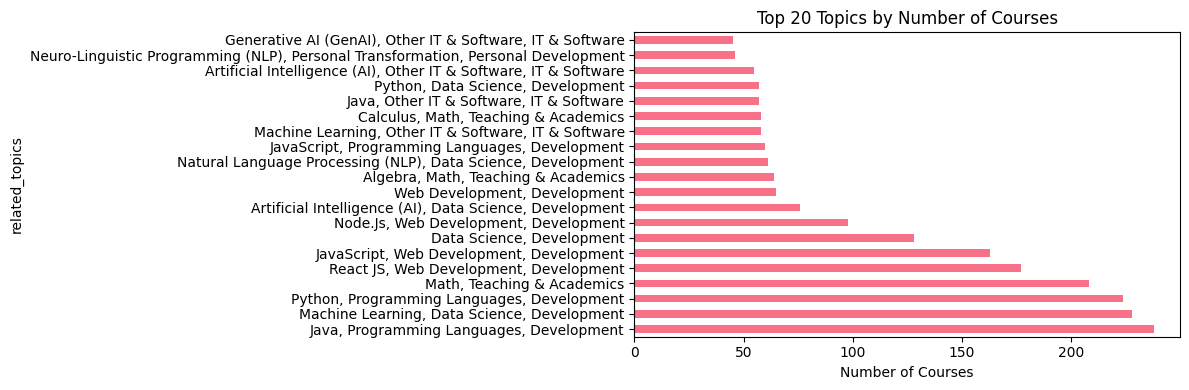


STEP 2: Creating sequences
✅ Created 243 sequences from 2409 topics

📊 Sequence Statistics:
   Avg length: 3.30 itemsets
   Avg skills per sequence: 4.60
   Min/Max length: 2/24

📋 Example Sequences (first 5):

1. Topic: AI Agents & Agentic AI, Data Science, Development
   Difficulties: Beginner → Beginner → Intermediate
   Sequence:
      Step 1: {ai, python}
      Step 2: {aws, azure, mlops}

2. Topic: AI Content Generation, Data Science, Development
   Difficulties: Beginner → Intermediate → Intermediate
   Sequence:
      Step 1: {ai}
      Step 2: {java, javascript}

3. Topic: API, Web Development, Development
   Difficulties: Beginner → Beginner → Beginner → Beginner
   Sequence:
      Step 1: {sql}
      Step 2: {java, javascript}

4. Topic: AWS Certified AI Practitioner, IT Certifications, IT & Software
   Difficulties: Beginner → Intermediate → Intermediate → Intermediate → Intermediate → Intermediate → Intermediate
   Sequence:
      Step 1: {ai, aws}
      Step 2: {machine 

In [ ]:

"""
🎯 Tạo sequences cho PrefixSpan
LOGIC:
1. Group by topic: Gom courses có cùng related_topics
2. Filter: Chỉ giữ topics có ≥3 courses
3. Sort by difficulty: Beginner → Intermediate → Advanced
4. Build sequence:
    - Duyệt qua từng course theo thứ tự độ khó
    - Chỉ thêm NEW skills chưa thấy vào sequence
    - Mỗi bước = 1 itemset chứa các kỹ năng mới
"""

print("📝 STEP-BY-STEP SEQUENCE PREPARATION\n")

# Step 1: Analyze topic groups
print("STEP 1: Analyze topic distribution")
topic_counts = df['related_topics'].value_counts()
print(f"   Total topics: {len(topic_counts)}")
print(f"   Topics with ≥3 courses: {(topic_counts >= 3).sum()}")
print(f"   Topics with ≥5 courses: {(topic_counts >= 5).sum()}")

# Visualize
plt.figure(figsize=(12, 4))
topic_counts.head(20).plot(kind='barh')
plt.title('Top 20 Topics by Number of Courses')
plt.xlabel('Number of Courses')
plt.tight_layout()
plt.show()

# Step 2: Create sequences with detailed tracking
print("\nSTEP 2: Creating sequences")

sequences = []
sequence_metadata = []  # For analysis

MIN_COURSES_PER_TOPIC = 3
topic_groups = df.groupby('related_topics')

for topic, group in topic_groups:
    if len(group) < MIN_COURSES_PER_TOPIC:
        continue
    
    # Sort by difficulty progression
    difficulty_order = {'Beginner': 0, 'Intermediate': 1, 'Advanced': 2}
    group = group.copy()
    group['diff_order'] = group['difficulty'].map(difficulty_order)
    group_sorted = group.sort_values(['diff_order', 'num_students'], 
                                     ascending=[True, False])
    
    # Build sequence
    sequence = []
    seen_skills_global = set()
    
    for idx, course in group_sorted.iterrows():
        course_skills = set(course['extracted_skills'])
        
        # Only add NEW skills to sequence
        new_skills = course_skills - seen_skills_global
        
        if new_skills:  # Only if there are new skills
            sequence.append(tuple(sorted(new_skills)))
            seen_skills_global.update(new_skills)
    
    # Store if meaningful
    if len(sequence) >= 2:
        sequences.append(sequence)
        sequence_metadata.append({
            'topic': topic,
            'num_courses': len(group),
            'sequence_length': len(sequence),
            'total_skills': len(seen_skills_global),
            'difficulties': group_sorted['difficulty'].tolist()
        })

print(f"✅ Created {len(sequences)} sequences from {len(topic_groups)} topics")

# Analyze sequences
metadata_df = pd.DataFrame(sequence_metadata)
print(f"\n📊 Sequence Statistics:")
print(f"   Avg length: {metadata_df['sequence_length'].mean():.2f} itemsets")
print(f"   Avg skills per sequence: {metadata_df['total_skills'].mean():.2f}")
print(f"   Min/Max length: {metadata_df['sequence_length'].min()}/{metadata_df['sequence_length'].max()}")

# Show examples
print(f"\n📋 Example Sequences (first 5):")
for i, (seq, meta) in enumerate(zip(sequences[:5], sequence_metadata[:5]), 1):
    print(f"\n{i}. Topic: {meta['topic']}")
    print(f"   Difficulties: {' → '.join(meta['difficulties'])}")
    print(f"   Sequence:")
    for j, itemset in enumerate(seq, 1):
        skills_str = ', '.join(list(itemset)[:3])
        if len(itemset) > 3:
            skills_str += f', ... (+{len(itemset)-3})'
        print(f"      Step {j}: {{{skills_str}}}")

🔍 RUNNING PREFIXSPAN ALGORITHM


Mining with min_support = 5
   Patterns found: 84
   Avg pattern length: 1.68
   Max pattern length: 3
   Unique skills involved: 24

Mining with min_support = 10
   Patterns found: 30
   Avg pattern length: 1.47
   Max pattern length: 2
   Unique skills involved: 15

Mining with min_support = 15
   Patterns found: 12
   Avg pattern length: 1.17
   Max pattern length: 2
   Unique skills involved: 10

Mining with min_support = 20
   Patterns found: 12
   Avg pattern length: 1.17
   Max pattern length: 2
   Unique skills involved: 10


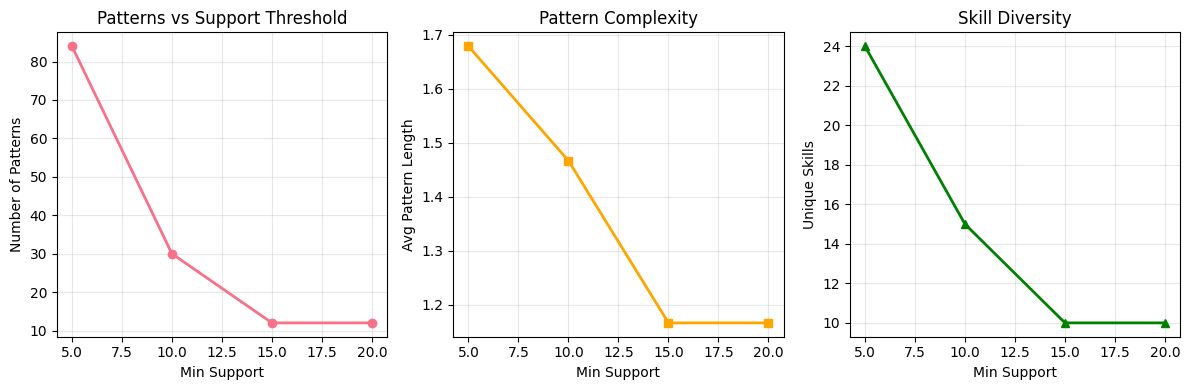

In [ ]:

"""
🎯 Chạy PrefixSpan và phân tích kết quả

THAM SỐ QUAN TRỌNG:
- min_support: minimum number of sequences containing the pattern
  * Quá cao → ít patterns, nhưng very frequent
  * Quá thấp → nhiều patterns, nhưng có thể noise
"""

print("🔍 RUNNING PREFIXSPAN ALGORITHM\n")

# Try different support thresholds
support_thresholds = [5, 10, 15, 20]

results_by_support = {}

for min_sup in support_thresholds:
    print(f"\n{'='*60}")
    print(f"Mining with min_support = {min_sup}")
    print(f"{'='*60}")
    
    ps = PrefixSpan(sequences)
    patterns = ps.frequent(minsup=min_sup)
    
    # Analyze patterns
    pattern_lengths = [len(p[1]) for p in patterns]
    unique_skills_count = set()
    for _, pattern in patterns:
        for itemset in pattern:
            if isinstance(itemset, (list, tuple)):
                unique_skills_count.update(itemset)
            else:
                unique_skills_count.add(itemset)
    
    results_by_support[min_sup] = {
        'num_patterns': len(patterns),
        'avg_length': np.mean(pattern_lengths) if pattern_lengths else 0,
        'max_length': max(pattern_lengths) if pattern_lengths else 0,
        'unique_skills': len(unique_skills_count),
        'patterns': patterns
    }
    
    print(f"   Patterns found: {len(patterns)}")
    print(f"   Avg pattern length: {np.mean(pattern_lengths):.2f}")
    print(f"   Max pattern length: {max(pattern_lengths)}")
    print(f"   Unique skills involved: {len(unique_skills_count)}")

# Visualize impact of support threshold
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(support_thresholds, 
         [results_by_support[s]['num_patterns'] for s in support_thresholds],
         marker='o', linewidth=2)
plt.xlabel('Min Support')
plt.ylabel('Number of Patterns')
plt.title('Patterns vs Support Threshold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(support_thresholds,
         [results_by_support[s]['avg_length'] for s in support_thresholds],
         marker='s', linewidth=2, color='orange')
plt.xlabel('Min Support')
plt.ylabel('Avg Pattern Length')
plt.title('Pattern Complexity')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(support_thresholds,
         [results_by_support[s]['unique_skills'] for s in support_thresholds],
         marker='^', linewidth=2, color='green')
plt.xlabel('Min Support')
plt.ylabel('Unique Skills')
plt.title('Skill Diversity')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

- Tham số min_support:
    - min_support = 5: 84 patterns (nhiều nhưng có noise)
    - min_support = 10: 30 patterns ← CHỌN
    - min_support = 15: 12 patterns (quá ít)
    - min_support = 20: 12 patterns

In [65]:

"""
🎯 Format và hiểu patterns

Pattern format: [(support, [(item1,), (item2, item3), ...])]
- Each tuple = một itemset
- Thứ tự quan trọng: A → B nghĩa là học A trước B
"""

def format_pattern(pattern, max_items_per_set=3):
    """Convert pattern to readable string"""
    formatted_items = []
    for itemset in pattern:
        if isinstance(itemset, (list, tuple)):
            items = list(itemset)[:max_items_per_set]
            if len(itemset) > max_items_per_set:
                items_str = ', '.join(items) + f', ... (+{len(itemset)-max_items_per_set})'
            else:
                items_str = ', '.join(items)
        else:
            items_str = str(itemset)
        formatted_items.append(f'{{{items_str}}}')
    return ' → '.join(formatted_items)

# Analyze patterns from optimal support (e.g., 10)
OPTIMAL_SUPPORT = 10
patterns = results_by_support[OPTIMAL_SUPPORT]['patterns']

print(f"🔥 TOP 20 FREQUENT PATTERNS (min_support={OPTIMAL_SUPPORT})\n")
print(f"{'#':<4} {'Support':<10} {'Length':<8} {'Pattern'}")
print("="*100)

# Sort by support descending
patterns_sorted = sorted(patterns, key=lambda x: x[0], reverse=True)

for i, (support, pattern) in enumerate(patterns_sorted[:20], 1):
    pattern_str = format_pattern(pattern)
    support_pct = (support / len(sequences)) * 100
    print(f"{i:<4} {support:<4} ({support_pct:4.1f}%)  {len(pattern):<8} {pattern_str}")

🔥 TOP 20 FREQUENT PATTERNS (min_support=10)

#    Support    Length   Pattern
1    119  (49.0%)  1        {ai}
2    73   (30.0%)  1        {python}
3    57   (23.5%)  1        {machine learning}
4    50   (20.6%)  1        {java}
5    41   (16.9%)  1        {sql}
6    35   (14.4%)  1        {java, javascript}
7    28   (11.5%)  1        {aws}
8    25   (10.3%)  1        {nlp}
9    23   ( 9.5%)  2        {ai} → {machine learning}
10   21   ( 8.6%)  1        {excel}
11   20   ( 8.2%)  2        {ai} → {python}
12   20   ( 8.2%)  1        {deep learning}
13   14   ( 5.8%)  2        {java, javascript} → {ai}
14   14   ( 5.8%)  1        {r programming}
15   13   ( 5.3%)  2        {ai} → {aws}
16   13   ( 5.3%)  2        {ai} → {excel}
17   13   ( 5.3%)  2        {python} → {machine learning}
18   12   ( 4.9%)  2        {ai} → {sql}
19   12   ( 4.9%)  1        {neural network}
20   11   ( 4.5%)  2        {ai} → {nlp}


- Single-skill patterns: Kỹ năng phổ biến nhất
- 2-step patterns: Progression phổ biến
    - {ai} → {machine learning}: Học AI concepts trước, sau đó ML algorithms
    - {python} → {machine learning}: Học Python trước, sau đó apply vào ML

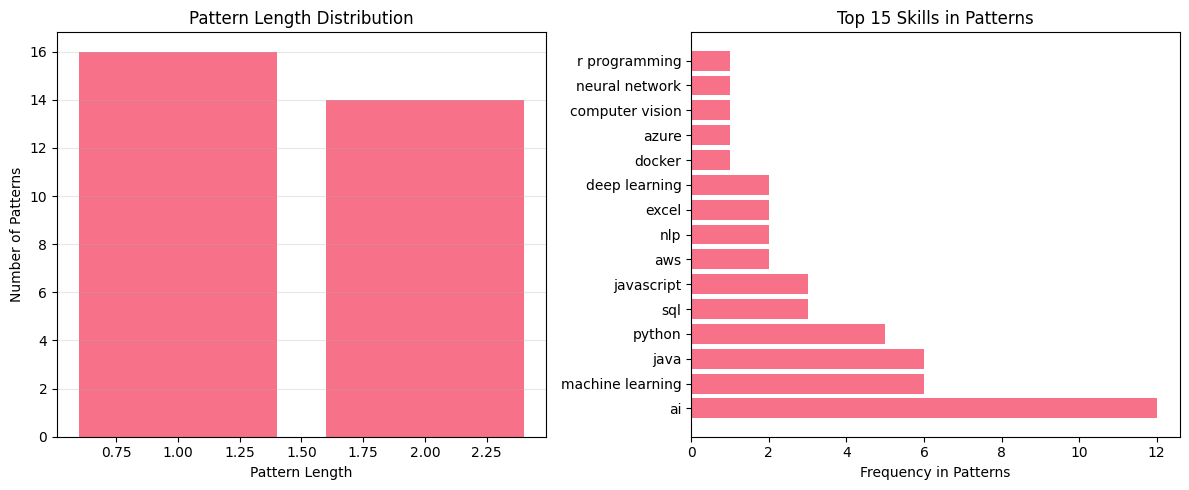


📊 Top Skills in Learning Patterns:
   ai                            :   12 patterns ( 40.0%)
   machine learning              :    6 patterns ( 20.0%)
   java                          :    6 patterns ( 20.0%)
   python                        :    5 patterns ( 16.7%)
   sql                           :    3 patterns ( 10.0%)
   javascript                    :    3 patterns ( 10.0%)
   aws                           :    2 patterns (  6.7%)
   nlp                           :    2 patterns (  6.7%)
   excel                         :    2 patterns (  6.7%)
   deep learning                 :    2 patterns (  6.7%)
   docker                        :    1 patterns (  3.3%)
   azure                         :    1 patterns (  3.3%)
   computer vision               :    1 patterns (  3.3%)
   neural network                :    1 patterns (  3.3%)
   r programming                 :    1 patterns (  3.3%)


In [66]:
"""
🎯 Phân tích patterns để hiểu learning paths
"""

# 1. Pattern length distribution
pattern_lengths = Counter([len(p[1]) for p in patterns])

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
lengths = sorted(pattern_lengths.keys())
counts = [pattern_lengths[l] for l in lengths]
plt.bar(lengths, counts)
plt.xlabel('Pattern Length')
plt.ylabel('Number of Patterns')
plt.title('Pattern Length Distribution')
plt.grid(True, alpha=0.3, axis='y')

# 2. Most frequent skills in patterns
skill_frequency = Counter()
for support, pattern in patterns:
    for itemset in pattern:
        if isinstance(itemset, (list, tuple)):
            skill_frequency.update(itemset)
        else:
            skill_frequency.add(itemset)

plt.subplot(1, 2, 2)
top_skills = skill_frequency.most_common(15)
skills, freqs = zip(*top_skills)
plt.barh(range(len(skills)), freqs)
plt.yticks(range(len(skills)), skills)
plt.xlabel('Frequency in Patterns')
plt.title('Top 15 Skills in Patterns')
plt.tight_layout()
plt.show()

print("\n📊 Top Skills in Learning Patterns:")
for skill, freq in top_skills:
    pct = (freq / len(patterns)) * 100
    print(f"   {skill:30s}: {freq:4d} patterns ({pct:5.1f}%)")

- Xác định những kỹ năng "cốt lõi" xuất hiện nhiều trong learning paths 
    - AI: Xuất hiện trong 40% patterns
    - Machine Learning: 20% patterns
    - Python: 16.7% patterns


In [ ]:
"""
🎯 Sử dụng patterns để recommend courses

STRATEGY:
1. Identify patterns relevant to career goal
2. Extract key skills from patterns
3. Find courses matching skill progression
4. Order by difficulty and pattern alignment

EXAMPLE: 
1. User input: "AI Engineer"
2. Tìm patterns có chứa ["ai", "machine learning", "deep learning"]
3. Extract key skills từ patterns (weighted by support)
4. Score courses dựa trên:
   - Pattern alignment score = ∑(support của skills có trong course)
   - Keyword match score
5. Sort by difficulty + score
6. Select balanced path (2-3 courses mỗi level)
"""

def generate_learning_path(career_goal, patterns, df, max_courses=7):
    """Generate pattern-based learning path"""
    
    # Career-specific keywords
    career_keywords = {
        # --- AI / ML Specialist ---
    'AI Engineer': ['ai', 'machine learning', 'deep learning', 'neural network'],
    'ML Engineer': ['machine learning', 'mlops', 'deployment', 'aws', 'tensorflow', 'pytorch'],
    'NLP Engineer': ['nlp', 'natural language', 'transformer', 'bert', 'hugging face'],
    'Computer Vision': ['computer vision', 'cnn', 'image', 'opencv', 'yolo'],
    
    # --- Data Roles ---
    'Data Scientist': ['data science', 'machine learning', 'statistics', 'python', 'pandas', 'r'],
    'Data Analyst': ['data analyst', 'sql', 'tableau', 'power bi', 'excel', 'visualization'],
    'Data Engineer': ['data engineer', 'etl', 'pipeline', 'spark', 'airflow', 'big data', 'sql'],
    
    # --- Cloud & DevOps ---
    'Cloud Engineer': ['cloud', 'aws', 'azure', 'gcp', 'infrastructure', 'iaas'],
    'DevOps Engineer': ['devops', 'ci/cd', 'docker', 'kubernetes', 'terraform', 'ansible', 'jenkins'],
    'Solutions Architect': ['solutions architect', 'aws', 'azure', 'cloud architecture', 'design'],

    # --- Software Development ---
    'Backend Developer': ['backend', 'api', 'node.js', 'django', 'fastapi', 'spring boot', 'database'],
    'Full Stack Developer': ['full stack', 'react', 'node.js', 'javascript', 'html', 'css', 'api'],
    'Web Developer': ['web development', 'html', 'css', 'javascript', 'react', 'frontend'],
    'Software Engineer': ['software engineer', 'data structures', 'algorithms', 'system design', 'java', 'python']
    }
    
    keywords = career_keywords.get(career_goal, ['python', 'machine learning'])
    
    print(f"\n🎯 Generating Learning Path: {career_goal}")
    print(f"   Career Keywords: {', '.join(keywords)}\n")
    
    # Step 1: Find relevant patterns
    relevant_patterns = []
    for support, pattern in patterns:
        pattern_skills = set()
        for itemset in pattern:
            if isinstance(itemset, (list, tuple)):
                pattern_skills.update(itemset)
            else:
                pattern_skills.add(itemset)
        
        # Check if pattern matches career
        if any(kw in skill for kw in keywords for skill in pattern_skills):
            relevant_patterns.append((support, pattern, pattern_skills))
    
    print(f"   Found {len(relevant_patterns)} relevant patterns")
    
    # Step 2: Extract key skills from patterns (weighted by support)
    skill_importance = Counter()
    for support, pattern, skills in relevant_patterns:
        for skill in skills:
            skill_importance[skill] += support  # Weight by support
    
    top_skills = [skill for skill, _ in skill_importance.most_common(15)]
    print(f"   Top skills: {', '.join(top_skills[:10])}")
    
    # Step 3: Score courses
    scored_courses = []
    for idx, row in df.iterrows():
        course_skills = set(row['extracted_skills'])
        
        # Pattern alignment score
        pattern_score = sum(skill_importance[skill] for skill in course_skills if skill in skill_importance)
        
        # Keyword match score
        keyword_score = sum(1 for kw in keywords if kw in str(row['full_content']).lower())
        
        total_score = pattern_score * 2 + keyword_score
        
        if total_score > 0:
            scored_courses.append({
                'title': row['title'],
                'difficulty': row['difficulty'],
                'rating': row['rating'],
                'num_students': row['num_students'],
                'duration_minutes': row['duration_minutes'],
                'skills': list(course_skills),
                'pattern_score': pattern_score,
                'keyword_score': keyword_score,
                'total_score': total_score
            })
    
    print(f"   Found {len(scored_courses)} matching courses")
    
    # Step 4: Select with progression
    difficulty_order = {'Beginner': 0, 'Intermediate': 1, 'Advanced': 2}
    scored_courses.sort(key=lambda x: (
        difficulty_order[x['difficulty']],
        -x['total_score']
    ))
    
    # Balanced selection
    selected = []
    diff_count = {'Beginner': 0, 'Intermediate': 0, 'Advanced': 0}
    max_per_diff = max(2, max_courses // 3)
    
    for course in scored_courses:
        diff = course['difficulty']
        if diff_count[diff] < max_per_diff and len(selected) < max_courses:
            selected.append(course)
            diff_count[diff] += 1
    
    # Fill remaining
    for course in scored_courses:
        if course not in selected and len(selected) < max_courses:
            selected.append(course)
    
    return selected[:max_courses]

# Generate paths
career_goals = ['AI Engineer', 'Data Scientist', 'NLP Engineer', 'Computer Vision', 'Web Developer', 'Software Engineer', 'Full Stack Developer', 'Backend Developer', 'Solutions Architect', 'DevOps Engineer', 'Cloud Engineer', 'Data Engineer', 'Data Analyst']

for goal in career_goals:
    path = generate_learning_path(goal, patterns, df, max_courses=5)
    
    print(f"\n{'='*80}")
    print(f"📚 LEARNING PATH: {goal}")
    print(f"{'='*80}")
    
    for i, course in enumerate(path, 1):
        duration_hrs = course['duration_minutes'] / 60 if course['duration_minutes'] else 0
        print(f"\n{i}. [{course['difficulty']}] {course['title']}")
        print(f"   Rating: {course['rating']:.1f}⭐ | Students: {course['num_students']:,.0f}")
        print(f"   Duration: ~{duration_hrs:.1f}h")
        print(f"   Pattern Score: {course['pattern_score']} | Skills: {', '.join(course['skills'][:3])}")
    
    print()


🎯 Generating Learning Path: AI Engineer
   Career Keywords: ai, machine learning, deep learning, neural network

   Found 18 relevant patterns
   Top skills: ai, machine learning, python, java, deep learning, javascript, aws, excel, sql, neural network
   Found 4677 matching courses

📚 LEARNING PATH: AI Engineer

1. [Beginner] The Introduction of AI and Machine Learning with Python
   Rating: 4.5⭐ | Students: 286
   Duration: ~5.4h
   Pattern Score: 477 | Skills: machine learning, deep learning, python

2. [Beginner] Introduction to AI, Machine Learning and Python basics
   Rating: 4.2⭐ | Students: 4,758
   Duration: ~2.6h
   Pattern Score: 446 | Skills: machine learning, python, ai

3. [Intermediate] Make predictions with Python machine learning for apps
   Rating: 4.3⭐ | Students: 572
   Duration: ~17.4h
   Pattern Score: 513 | Skills: tensorflow, machine learning, ai

4. [Intermediate] 5-in-1 Mega Course: Python, Javascript, React JS, CSS, AI
   Rating: 4.4⭐ | Students: 4,595
   Du

In [ ]:
"""
🎯 Save results for further analysis or deployment
"""

# Export patterns
pattern_df = pd.DataFrame([
    {
        'support': support,
        'support_pct': support / len(sequences) * 100,
        'length': len(pattern),
        'pattern': format_pattern(pattern),
        'skills': list(set([
            skill for itemset in pattern 
            for skill in (itemset if isinstance(itemset, (list, tuple)) else [itemset])
        ]))
    }
    for support, pattern in patterns
])

pattern_df.to_csv('mined_patterns.csv', index=False)
print(f"✅ Exported {len(pattern_df)} patterns to 'mined_patterns.csv'")

# Summary statistics
print(f"\n{'='*80}")
print("📊 MINING SUMMARY")
print(f"{'='*80}")
print(f"   Total sequences: {len(sequences)}")
print(f"   Patterns mined (min_sup={OPTIMAL_SUPPORT}): {len(patterns)}")
print(f"   Avg pattern length: {pattern_df['length'].mean():.2f}")
print(f"   Unique skills in patterns: {len(skill_frequency)}")
print(f"   Most common pattern length: {pattern_df['length'].mode()[0]}")
print(f"{'='*80}")

✅ Exported 30 patterns to 'mined_patterns.csv'

📊 MINING SUMMARY
   Total sequences: 243
   Patterns mined (min_sup=10): 30
   Avg pattern length: 1.47
   Unique skills in patterns: 15
   Most common pattern length: 1


## 🔄 Tổng kết Workflow

```
📊 Raw Data (10,181 courses)
    ↓
🔍 Extract Skills (TF-IDF + Keywords)
    ↓
📏 Estimate Difficulty (Multi-signal)
    ↓
📦 Group by Topics (2,409 topics)
    ↓
🔗 Create Sequences (243 sequences)
   [Beginner courses] → [Intermediate] → [Advanced]
    ↓
⛏️ PrefixSpan Mining (min_support=10)
    ↓
📋 30 Frequent Patterns
   {ai}, {python}, {ai}→{ML}, ...
    ↓
🎯 Generate Learning Paths
   Input: Career Goal
   Output: Ranked Course List
```